# Bayesian A/B Test Analysis: Binary Outcomes (Rates)
This notebook performs a Bayesian analysis of an A/B test with a binary outcome (e.g., click/no-click, open/no-open, conversion/no-conversion).

The primary outputs are:

1. The probability that the treatment group's rate is greater than the control group's.
1. The expected absolute and relative change between the two groups.
1. The 95% Credible Intervals for the change.
1. Posterior distribution plots for visualization.

### 1. Configuration & Data Input

This is the only cell you need to edit.

- `EVENT_COUNT_CONTROL_GROUP`: The number of users in the **control group** who performed the target action (e.g., opened an email).

- `TOTAL_COUNT_CONTROL_GROUP`: The total number of users or observations in the **control group**.  
  Example: Number of emails sent to the control group.

- `EVENT_COUNT_TREATMENT_GROUP`: The number of users in the **treatment group** who performed the target action.

- `TOTAL_COUNT_TREATMENT_GROUP`: The total number of users or observations in the **treatment group**.

- `METRIC_NAME`: A descriptive string for the binary metric you're testing (e.g., "Open Rate", "Click Rate").  
  Used in plot titles and analysis summaries.

- `PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA`: The minimum **relative** change in the metric that you consider practically meaningful.  
  Example: If your baseline rate is 20% and you set this to `0.05` (5%), you are asking:  
  *"What is the probability that the treatment group’s rate is at least 5% greater than the control group's rate (i.e., a rate of 21%)?"*

- `N_SAMPLES`: The number of samples to draw in the **Monte Carlo simulation**.  
  A large number (e.g., 500,000) is used to approximate the posterior distributions of each group’s true rate.  
  This allows us to compute probabilities, credible intervals, and estimate the difference in performance between groups.  
  The larger this number is, the more accurate are the estimations.


In [1]:
# --- CONFIGURE YOUR TEST DATA HERE ---

# Control Group Data
EVENT_COUNT_CONTROL_GROUP = 2010
TOTAL_COUNT_CONTROL_GROUP = 10000

# Treatment Group Data
EVENT_COUNT_TREATMENT_GROUP = 2170
TOTAL_COUNT_TREATMENT_GROUP = 10050

# --- ANALYSIS PARAMETERS ---

METRIC_NAME = "Open Rate"

# Set the desired relative lift that you consider practically significant (e.g., 0.02 for a 2% lift)
PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA = 0.05

N_SAMPLES = 500_000

### 2. Analysis Setup
This cell imports the necessary libraries and prints the configuration to confirm the inputs.

In [2]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# --- Print Setup and Input Data ---
print("="*80)
print(f" BAYESIAN A/B TEST: {METRIC_NAME}")
print("="*80)

print("\nInput Data:")
print(f"- Control Data:     {EVENT_COUNT_CONTROL_GROUP} events / {TOTAL_COUNT_CONTROL_GROUP} total -> Observed Rate: {EVENT_COUNT_CONTROL_GROUP/TOTAL_COUNT_CONTROL_GROUP:.2%}")
print(f"- Treatment Data:   {EVENT_COUNT_TREATMENT_GROUP} events / {TOTAL_COUNT_TREATMENT_GROUP} total -> Observed Rate: {EVENT_COUNT_TREATMENT_GROUP/TOTAL_COUNT_TREATMENT_GROUP:.2%}")
print("\nAnalysis Parameters:")
print(f"  - Practical Significance Threshold (Relative δ): {PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA:.1%}")

 BAYESIAN A/B TEST: Open Rate

Input Data:
- Control Data:     2010 events / 10000 total -> Observed Rate: 20.10%
- Treatment Data:   2170 events / 10050 total -> Observed Rate: 21.59%

Analysis Parameters:
  - Practical Significance Threshold (Relative δ): 5.0%


### 3. Bayesian Model Definition

We model the unknown true rate **θ** for each group using a Bayesian framework.

- **Prior Distribution**:  
  We use the **Jeffreys prior**, which corresponds to a `Beta(0.5, 0.5)` distribution. This is popular choice for an "uninformative" prior that encodes minimal assumptions, allowing the data to drive the results.

  - This choice is especially appropriate given the **large sample sizes** common in A/B testing, where there is enough data to drive the inference.

  - Incorporating historical data as a prior is another point of subjectivity and arbitrariness, which we avoid by using the Jeffreys prior.

  - A bonus justification: the Jeffreys prior is **invariant under reparameterization**, meaning that inferences remain consistent even if we transform the parameter (e.g., from `θ` to `log-odds(θ)`).

- **Likelihood**:  
  The observed data (i.e., the number of event occurrences out of the total) is modeled using a **Binomial distribution**, where:
  
  - `x` is the number of observed events,
  - `n` is the total number of observations, and
  - `θ` is the unknown true event rate.

- **Posterior Distribution**:
  Because the Beta distribution is conjugate to the Binomial likelihood, the posterior distribution of **θ** is also a Beta distribution, with updated parameters:
  
  - `θ ~ Beta(x + 0.5, n - x + 0.5)`

  This posterior captures our updated beliefs about the true event rate after observing the data.


In [3]:
# --- Bayesian Model Calculation with Jeffreys Prior ---
alpha_prior = 0.5
beta_prior = 0.5

# Calculate posterior parameters for the Control group
alpha_post_control = alpha_prior + EVENT_COUNT_CONTROL_GROUP
beta_post_control = beta_prior + (TOTAL_COUNT_CONTROL_GROUP - EVENT_COUNT_CONTROL_GROUP)

# Calculate posterior parameters for the Treatment group
alpha_post_treatment = alpha_prior + EVENT_COUNT_TREATMENT_GROUP
beta_post_treatment = beta_prior + (TOTAL_COUNT_TREATMENT_GROUP - EVENT_COUNT_TREATMENT_GROUP)


# --- Print Model Parameters ---
print("--- Bayesian Model Parameters ---")
print("\nPrior Distribution:")
print(f"  - Type: Jeffreys Prior")
print(f"  - Distribution: Beta(α={alpha_prior}, β={beta_prior})")

print("\nPosterior Distributions (After Updating with Experiment Data):")
print(f"  - Control Posterior:   Beta(α={alpha_post_control:.1f}, β={beta_post_control:.1f})")
print(f"  - Treatment Posterior: Beta(α={alpha_post_treatment:.1f}, β={beta_post_treatment:.1f})")

--- Bayesian Model Parameters ---

Prior Distribution:
  - Type: Jeffreys Prior
  - Distribution: Beta(α=0.5, β=0.5)

Posterior Distributions (After Updating with Experiment Data):
  - Control Posterior:   Beta(α=2010.5, β=7990.5)
  - Treatment Posterior: Beta(α=2170.5, β=7880.5)


### 4. Results

We now draw a large number of samples from the posterior distributions of both groups to simulate the range of plausible values for their true rates. This **Monte Carlo simulation** allows us to compute probabilities and credible intervals for the difference between the groups.

#### Visualizations

- **Posterior Distributions**  
  Displays the probability density of the true event rate for both the control and treatment groups.  
  The degree of overlap between the two distributions reflects the level of uncertainty in distinguishing them.

- **Distribution of Absolute Change (Treatment − Control)**  
  Shows the distribution of the *difference* in rates between the treatment and control groups.  
  This visualization highlights the expected change and its credible interval, helping to assess whether the treatment effect is practically and statistically significant.

- **Distribution of Relative Change ((Treatment - Control) / Control)**  
  Shows the distribution of the *percentage* change in rates. This is useful for understanding the magnitude of the improvement relative to the baseline performance.


--- Results ---

Probabilities:
  - Probability Treatment > Control: 99.53%
    (The probability that the treatment's true rate is numerically greater than the control's.)
  - Prob. Treatment is Practically Significant: 79.56%
    (The probability the relative change exceeds our threshold of 5.0%.)

Absolute Change Estimation (Rate_Treatment - Rate_Control):
  - Expected Absolute Change: 0.01492 (or 1.492 pp)
    (Our best estimate for the absolute change in the rate.)
  - 95% Highest Density Interval (HDI) for Absolute Change: [0.00372, 0.02625]
    (The 95% HDI is the narrowest interval containing 95% of the posterior probability,
     representing the range of most credible values.)

Relative Change Estimation ((Rate_Treatment - Rate_Control) / Rate_Control):
  - Expected Relative Change: 7.46%
    (The expected percentage change in the rate relative to the control group.)
  - 95% Highest Density Interval (HDI) for Relative Change: [1.70%, 13.33%]
    (The 95% HDI is the narrowest 

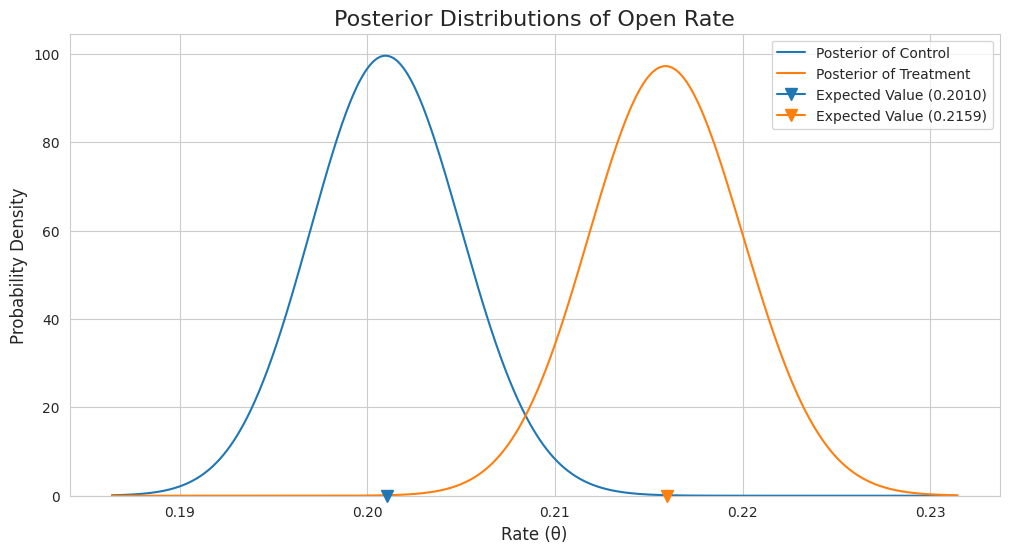

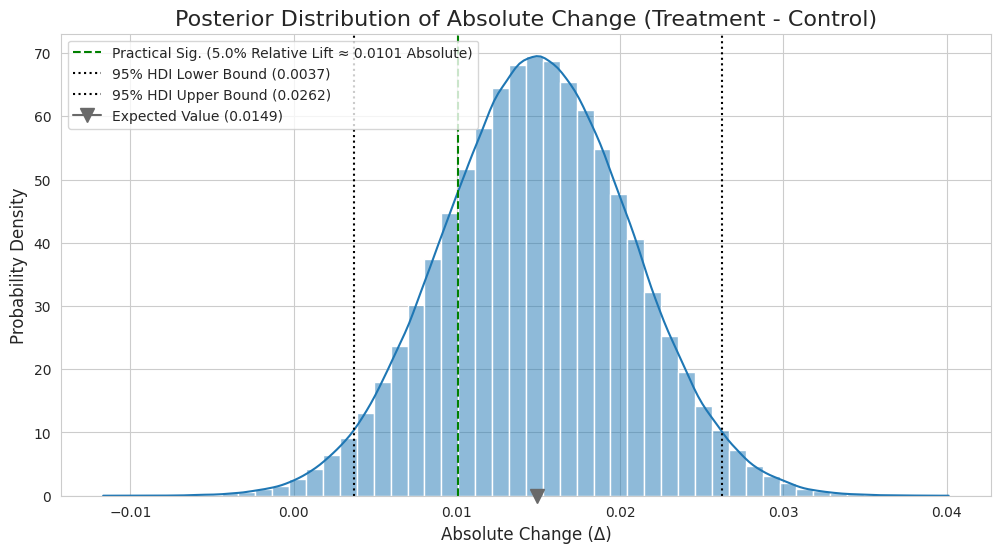

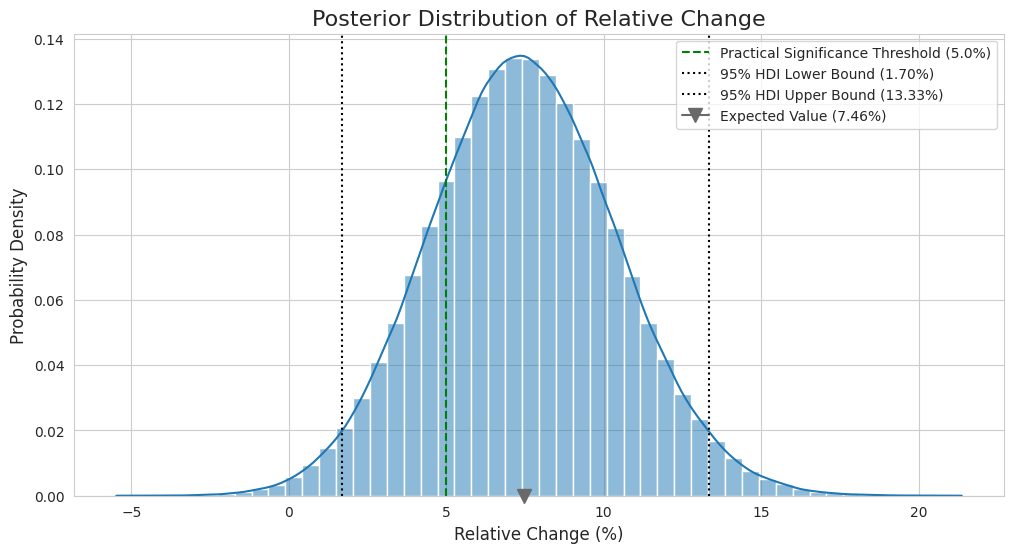

In [4]:
# --- Simulation from Posterior Distributions ---
samples_control = beta.rvs(alpha_post_control, beta_post_control, size=N_SAMPLES)
samples_treatment = beta.rvs(alpha_post_treatment, beta_post_treatment, size=N_SAMPLES)

# Calculate the distribution of the difference (uplift)
uplift_samples = samples_treatment - samples_control
# Prevent division by zero, although highly unlikely with beta posteriors from real data
relative_uplift_samples = (samples_treatment - samples_control) / np.where(samples_control == 0, 1e-18, samples_control)

# --- Calculate Core Metrics ---
prob_treatment_is_greater = np.mean(samples_treatment > samples_control)
prob_treatment_is_practically_significant = np.mean(relative_uplift_samples > PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA)

# Calculate the 95% Highest Density Intervals (HDI) for the changes.
# The HDI is the narrowest interval containing 95% of the posterior probability.
abs_hdi = az.hdi(uplift_samples, hdi_prob=0.95)
rel_hdi = az.hdi(relative_uplift_samples, hdi_prob=0.95)
abs_hdi_lower, abs_hdi_upper = abs_hdi
rel_hdi_lower, rel_hdi_upper = rel_hdi

expected_absolute_change = np.mean(uplift_samples)
expected_relative_change = np.mean(relative_uplift_samples)


# --- Print Core Estimation Metrics ---
print("\n--- Results ---")
print("\nProbabilities:")
print(f"  - Probability Treatment > Control: {prob_treatment_is_greater:.2%}")
print(f"    (The probability that the treatment's true rate is numerically greater than the control's.)")
print(f"  - Prob. Treatment is Practically Significant: {prob_treatment_is_practically_significant:.2%}")
print(f"    (The probability the relative change exceeds our threshold of {PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA:.1%}.)")

print(f"\nAbsolute Change Estimation (Rate_Treatment - Rate_Control):")
print(f"  - Expected Absolute Change: {expected_absolute_change:.5f} (or {expected_absolute_change*100:.3f} pp)")
print(f"    (Our best estimate for the absolute change in the rate.)")
print(f"  - 95% Highest Density Interval (HDI) for Absolute Change: [{abs_hdi_lower:.5f}, {abs_hdi_upper:.5f}]")
print(f"    (The 95% HDI is the narrowest interval containing 95% of the posterior probability,")
print(f"     representing the range of most credible values.)")

print(f"\nRelative Change Estimation ((Rate_Treatment - Rate_Control) / Rate_Control):")
print(f"  - Expected Relative Change: {expected_relative_change:.2%}")
print(f"    (The expected percentage change in the rate relative to the control group.)")
print(f"  - 95% Highest Density Interval (HDI) for Relative Change: [{rel_hdi_lower:.2%}, {rel_hdi_upper:.2%}]")
print(f"    (The 95% HDI is the narrowest interval containing 95% of the posterior probability,")
print(f"     representing the range of most credible values.)")



# Plot 1: Posterior Distributions
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Determine plot range from the posteriors
x_min = min(beta.ppf(0.0001, alpha_post_control, beta_post_control), beta.ppf(0.0001, alpha_post_treatment, beta_post_treatment))
x_max = max(beta.ppf(0.9999, alpha_post_control, beta_post_control), beta.ppf(0.9999, alpha_post_treatment, beta_post_treatment))
x = np.linspace(x_min, x_max, 1000)

plt.plot(x, beta.pdf(x, alpha_post_control, beta_post_control), label='Posterior of Control')
plt.plot(x, beta.pdf(x, alpha_post_treatment, beta_post_treatment), label='Posterior of Treatment')

# Add markers for expected value
expected_control_rate = alpha_post_control / (alpha_post_control + beta_post_control)
expected_treatment_rate = alpha_post_treatment / (alpha_post_treatment + beta_post_treatment)
plt.plot([expected_control_rate], [0], marker='v', color='C0', markersize=8, clip_on=False, zorder=10, label=f'Expected Value ({expected_control_rate:.4f})')
plt.plot([expected_treatment_rate], [0], marker='v', color='C1', markersize=8, clip_on=False, zorder=10, label=f'Expected Value ({expected_treatment_rate:.4f})')

plt.title(f'Posterior Distributions of {METRIC_NAME}', fontsize=16)
plt.xlabel(f'Rate (θ)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.ylim(bottom=0) # Ensure markers on the x-axis are visible
plt.legend()
plt.show()



# Plot 2: Distribution of the Absolute Change with HDI
plt.figure(figsize=(12, 6))
sns.histplot(uplift_samples, bins=50, kde=True, stat="density")

# Calculate the absolute uplift equivalent of our relative significance threshold for visualization
absolute_threshold_equivalent = np.mean(samples_control) * PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA

# Add vertical lines for the practical significance threshold and the HDI bounds
plt.axvline(absolute_threshold_equivalent, color='green', linestyle='--',
            label=f"Practical Sig. ({PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA:.1%} Relative Lift ≈ {absolute_threshold_equivalent:.4f} Absolute)")
plt.axvline(abs_hdi_lower, color='black', linestyle=':', label=f"95% HDI Lower Bound ({abs_hdi_lower:.4f})")
plt.axvline(abs_hdi_upper, color='black', linestyle=':', label=f"95% HDI Upper Bound ({abs_hdi_upper:.4f})")

# Add marker for expected value
plt.plot([expected_absolute_change], [0], marker='v', color='dimgray', markersize=10, clip_on=False, zorder=10, label=f'Expected Value ({expected_absolute_change:.4f})')

plt.title(f'Posterior Distribution of Absolute Change (Treatment - Control)', fontsize=16)
plt.xlabel('Absolute Change (Δ)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.ylim(bottom=0) # Ensure marker on the x-axis is visible
plt.legend()
plt.show()


# Plot 3: Distribution of the Relative Change with HDI
plt.figure(figsize=(12, 6))
# Plotting as percentages for easier interpretation
sns.histplot(relative_uplift_samples * 100, bins=50, kde=True, stat="density")

# Add vertical lines for the practical significance threshold and HDI bounds (also as percentages)
plt.axvline(PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA * 100, color='green', linestyle='--',
            label=f"Practical Significance Threshold ({PRACTICAL_SIGNIFICANCE_RELATIVE_DELTA:.1%})")
plt.axvline(rel_hdi_lower * 100, color='black', linestyle=':', label=f"95% HDI Lower Bound ({rel_hdi_lower:.2%})")
plt.axvline(rel_hdi_upper * 100, color='black', linestyle=':', label=f"95% HDI Upper Bound ({rel_hdi_upper:.2%})")

# Add marker for expected value
plt.plot([expected_relative_change * 100], [0], marker='v', color='dimgray', markersize=10, clip_on=False, zorder=10, label=f'Expected Value ({expected_relative_change:.2%})')

plt.title(f'Posterior Distribution of Relative Change', fontsize=16)
plt.xlabel('Relative Change (%)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.ylim(bottom=0) # Ensure marker on the x-axis is visible
plt.legend()
plt.show()

### 5. Model Validation: Posterior Predictive Check (PPC)

A Posterior Predictive Check (PPC) helps us answer the question: *"Does my fitted model generate data that looks like my actual, observed data?"* If the simulated data is systematically different from the observed data, it suggests the model is a poor fit for the data or the underlying process.

For our Beta-Binomial model, the check works as follows:

1. We have already drawn many samples of the true rate **θ** from the posterior distribution for each group (e.g., `samples_control`).
2. For each sampled rate `θ`, we simulate a new "experiment" by drawing from the Binomial distribution: `new_event_count ~ Binomial(n=TOTAL_COUNT, p=θ)`.
3. This process generates a large distribution of *simulated* event counts, representing the range of outcomes our model "expects" to see, given the posterior.
4. We then compare the distribution of these simulated counts to the actual *observed* event count. If the observed count falls within a reasonable range of the simulated distribution, we can be more confident that our model is a good fit.

The plots below show the distribution of simulated event counts from the posterior predictive distribution for both the control and treatment groups. The red vertical line marks the actual observed event count from our experiment.

#### Interpreting the Bayesian P-Value

The **Bayesian p-value** is a diagnostic metric used in PPCs to quantify the discrepancy between the model's predictions and the actual data. It is fundamentally different from a frequentist p-value.

- **What it is:** It is the proportion of simulated data points from the posterior predictive distribution that are more extreme than the observed data point. In our case, the 'data point' is the event count.

- **How it's calculated:** We calculate `p_val = mean(simulated_counts >= observed_count)`. This tells us what fraction of our simulations resulted in an event count as large or larger than what we actually saw.

- **How to interpret it:**
  - A p-value around **0.50** is ideal. This indicates that the observed data is perfectly typical under the model; it sits right in the middle of the simulated data distribution.
  - A p-value near **0.0** or **1.0** suggests a **model misfit**. 
    - If the p-value is close to **0**, it means the observed count is much lower than what the model predicted. The model is systematically over-predicting the event count.
    - If the p-value is close to **1**, it means the observed count is much higher than what the model predicted. The model is systematically under-predicting the event count.

In short, the Bayesian p-value helps you trust your model. If the p-values are reasonable (e.g., between 0.05 and 0.95), you can be more confident that the Beta-Binomial model is a good description of your data generating process.


--- 5. Model Validation: Posterior Predictive Check Results ---

Control Group:
  - Observed Event Count:              2010
  - Mean of Simulated Counts (PPC Mean): 2010.44
  - Bayesian p-value:                    0.504

Treatment Group:
  - Observed Event Count:              2170
  - Mean of Simulated Counts (PPC Mean): 2170.19
  - Bayesian p-value:                    0.503


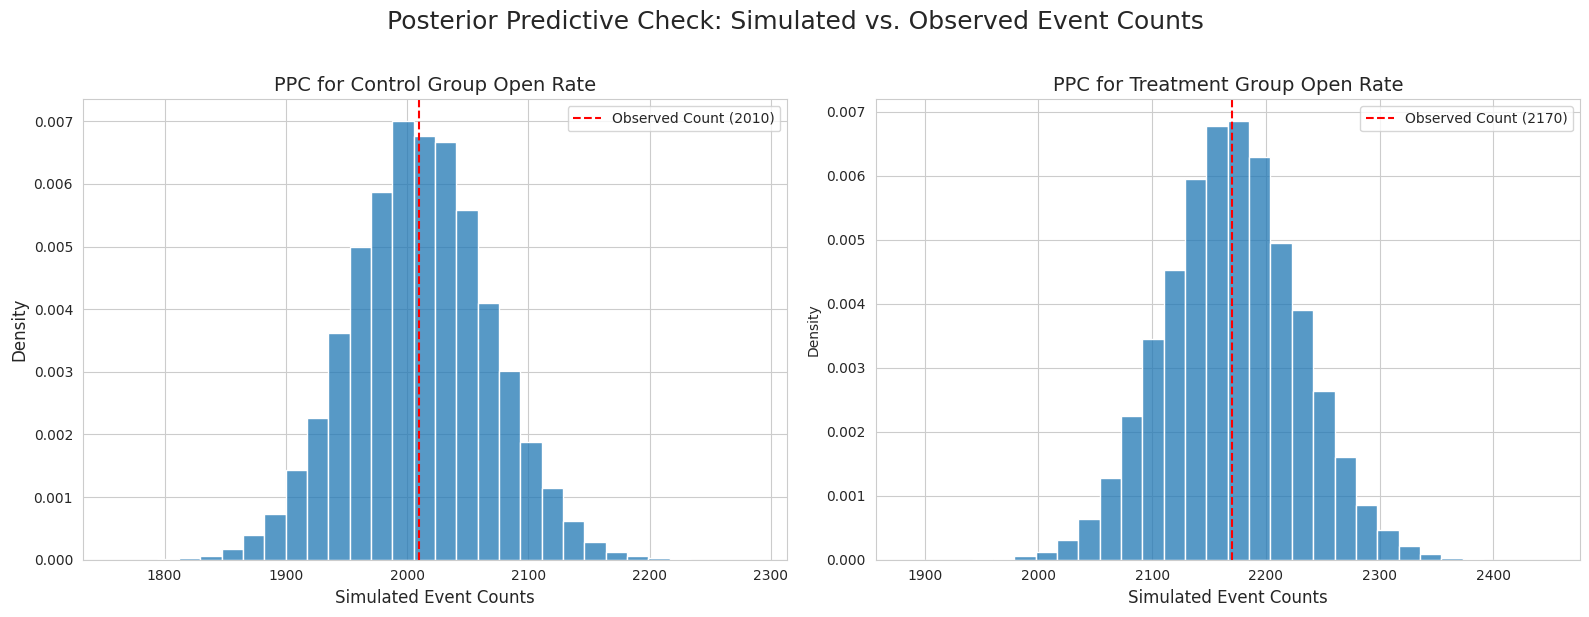

In [5]:
# --- Posterior Predictive Check ---

# Simulate new event counts from the posterior predictive distribution
# For each sample of the rate from the posterior, simulate one experiment's outcome
ppc_control = np.random.binomial(n=TOTAL_COUNT_CONTROL_GROUP, p=samples_control)
ppc_treatment = np.random.binomial(n=TOTAL_COUNT_TREATMENT_GROUP, p=samples_treatment)

# --- Calculate PPC Summary Statistics ---

# 1. Calculate the mean of the posterior predictive distributions
ppc_mean_control = np.mean(ppc_control)
ppc_mean_treatment = np.mean(ppc_treatment)

# 2. Calculate Bayesian p-values for the checks
# This is the proportion of simulated data that is as or more extreme than the observed data.
p_val_control = np.mean(ppc_control >= EVENT_COUNT_CONTROL_GROUP)
p_val_treatment = np.mean(ppc_treatment >= EVENT_COUNT_TREATMENT_GROUP)

# --- Print PPC Results ---
print("\n--- 5. Model Validation: Posterior Predictive Check Results ---\n")

print("Control Group:")
print(f"  - Observed Event Count:              {EVENT_COUNT_CONTROL_GROUP}")
print(f"  - Mean of Simulated Counts (PPC Mean): {ppc_mean_control:.2f}")
print(f"  - Bayesian p-value:                    {p_val_control:.3f}\n")

print("Treatment Group:")
print(f"  - Observed Event Count:              {EVENT_COUNT_TREATMENT_GROUP}")
print(f"  - Mean of Simulated Counts (PPC Mean): {ppc_mean_treatment:.2f}")
print(f"  - Bayesian p-value:                    {p_val_treatment:.3f}")


# --- Visualize the PPCs ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Control Group
sns.histplot(ppc_control, ax=ax1, bins=30, stat="density", kde=False)
ax1.axvline(EVENT_COUNT_CONTROL_GROUP, color='red', linestyle='--', label=f'Observed Count ({EVENT_COUNT_CONTROL_GROUP})')
ax1.set_title(f'PPC for Control Group {METRIC_NAME}', fontsize=14)
ax1.set_xlabel('Simulated Event Counts', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.legend()

# Plot for Treatment Group
sns.histplot(ppc_treatment, ax=ax2, bins=30, stat="density", kde=False)
ax2.axvline(EVENT_COUNT_TREATMENT_GROUP, color='red', linestyle='--', label=f'Observed Count ({EVENT_COUNT_TREATMENT_GROUP})')
ax2.set_title(f'PPC for Treatment Group {METRIC_NAME}', fontsize=14)
ax2.set_xlabel('Simulated Event Counts', fontsize=12)
ax2.legend()

plt.suptitle('Posterior Predictive Check: Simulated vs. Observed Event Counts', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()